In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2023-03-27 15:33:47.963263: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 15:33:48.544375: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0


In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
print(*physical_devices)

for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [56]:
dfs = []
for m in tqdm(np.arange(0.8, 1.22, 0.02)):
    df = pd.read_hdf("/var/local/Scratch/shared/data/mesa_grids/grid2p5a/grid.h5", key=f"m{m:.2f}")
#     df = df.loc[np.isclose(df.initial_Yinit, 0.28) & np.isclose(df.initial_MLT, 1.9)]
    dfs.append(df)
#     break
    
df = pd.concat(dfs)
del dfs
df.head()

  0%|          | 0/21 [00:00<?, ?it/s]

,index,dirname,filename,model_number,evol_stage,initial_mass,initial_Yinit,initial_Zinit,initial_feh,initial_MLT,...,nu_0_31,nu_0_32,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40
0,392,m0.8Y0.24FeH-0.4MLT1.9ov0.0006666666666666673dif1,profile396,544.0,1.0,0.8,0.24,0.005436,-0.4,1.9,...,6456.079105,6657.091422,6858.056869,7058.957096,7259.567887,7459.692965,7658.454375,7849.779957,8045.037236,8237.328858
1,393,m0.8Y0.24FeH-0.4MLT1.9ov0.0006666666666666673dif1,profile397,545.0,1.0,0.8,0.24,0.005436,-0.4,1.9,...,6507.298010,6709.892145,6912.386771,7114.937732,7317.128790,7518.925529,7719.561935,7914.214757,8109.455595,8303.599346
2,394,m0.8Y0.24FeH-0.4MLT1.9ov0.0006666666666666673dif1,profile398,546.0,1.0,0.8,0.24,0.005436,-0.4,1.9,...,6550.139566,6754.056420,6957.840451,7161.763972,7365.287950,7568.455878,7770.636476,7968.752342,8163.313575,8358.996174
3,395,m0.8Y0.24FeH-0.4MLT1.9ov0.0006666666666666673dif1,profile399,547.0,1.0,0.8,0.24,0.005436,-0.4,1.9,...,6589.620734,6794.752299,6999.740187,7204.907423,7409.678907,7614.101838,7817.676013,8017.974403,8212.939579,8410.041386
4,396,m0.8Y0.24FeH-0.4MLT1.9ov0.0006666666666666673dif1,profile400,548.0,1.0,0.8,0.24,0.005436,-0.4,1.9,...,6625.088258,6831.308924,7037.389682,7243.653232,7449.556793,7655.112820,7859.912451,8061.909568,8257.500979,8455.884939


In [57]:
df["log_age"] = np.log10(df["star_age"])
df["log_teff"] = np.log10(df["effective_T"])

## Drop data we do not need

### To do

Calculate EEP, this is much better!

In [59]:
mask = (
    (df.frac_age > 0.015) & (df.center_h1 > 1e-12)
    & np.isclose(df.initial_MLT, 1.9) & np.isclose(df.initial_Yinit, 0.28)
)
df = df.loc[mask]
df = df.drop(columns=[f"nu_0_{i}" for i in range(1, 41)])

In [122]:
def equiv_evol_phase(track, c=0.18):
    delta = (
        np.diff(track["log_teff"], prepend=track["log_teff"].iloc[0])**2
        + np.diff(track["log_g"], prepend=track["log_g"].iloc[0])**2
    )**c
    dist = delta.cumsum()
    return pd.Series(dist/dist.max(), index=track.index, name="EEP")

In [123]:
eep = df.groupby("dirname", sort=False).apply(equiv_evol_phase).reset_index(0)
eep

,dirname,EEP
71117,m0.8Y0.28FeH-0.4MLT1.9ov0.0006666666666666673dif1,0.000000
71118,m0.8Y0.28FeH-0.4MLT1.9ov0.0006666666666666673dif1,0.002120
71119,m0.8Y0.28FeH-0.4MLT1.9ov0.0006666666666666673dif1,0.004297
71120,m0.8Y0.28FeH-0.4MLT1.9ov0.0006666666666666673dif1,0.006542
71121,m0.8Y0.28FeH-0.4MLT1.9ov0.0006666666666666673dif1,0.008625
...,...,...
335047,m1.2Y0.28FeH-0.5MLT1.9ov0.006444444444444444dif0,0.986836
335048,m1.2Y0.28FeH-0.5MLT1.9ov0.006444444444444444dif0,0.990143
335049,m1.2Y0.28FeH-0.5MLT1.9ov0.006444444444444444dif0,0.993440
335050,m1.2Y0.28FeH-0.5MLT1.9ov0.006444444444444444dif0,0.996725


In [124]:
df["EEP"] = eep["EEP"]
df.head()

,index,dirname,filename,model_number,evol_stage,initial_mass,initial_Yinit,initial_Zinit,initial_feh,initial_MLT,...,log_center_T,log_center_Rho,he_core_mass,delta_nu,delta_Pg,nu_max,acoustic_cutoff,log_age,log_teff,EEP
71117,90430,m0.8Y0.28FeH-0.4MLT1.9ov0.0006666666666666673dif1,profile422,570.0,1.0,0.8,0.28,0.00515,-0.4,1.9,...,7.097652,1.978579,0.0,200.414139,0.0,4706.802932,6924.829249,-0.694277,3.747883,0.000000
71118,90431,m0.8Y0.28FeH-0.4MLT1.9ov0.0006666666666666673dif1,profile423,571.0,1.0,0.8,0.28,0.00515,-0.4,1.9,...,7.097654,1.979782,0.0,200.072099,0.0,4695.729712,6907.682936,-0.627572,3.747916,0.002120
71119,90432,m0.8Y0.28FeH-0.4MLT1.9ov0.0006666666666666673dif1,profile424,572.0,1.0,0.8,0.28,0.00515,-0.4,1.9,...,7.097756,1.981232,0.0,199.705040,0.0,4683.788759,6889.098548,-0.559069,3.747964,0.004297
71120,90433,m0.8Y0.28FeH-0.4MLT1.9ov0.0006666666666666673dif1,profile425,573.0,1.0,0.8,0.28,0.00515,-0.4,1.9,...,7.097959,1.982970,0.0,199.305494,0.0,4670.737094,6868.688556,-0.488991,3.748028,0.006542
71121,90434,m0.8Y0.28FeH-0.4MLT1.9ov0.0006666666666666673dif1,profile426,574.0,1.0,0.8,0.28,0.00515,-0.4,1.9,...,7.098172,1.984502,0.0,198.981749,0.0,4660.133332,6852.058183,-0.436474,3.748088,0.008625


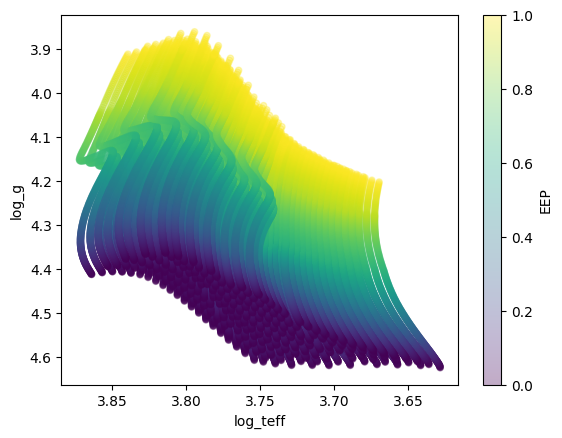

In [125]:
ax = df.plot(x="log_teff", y="log_g", c="EEP", kind="scatter", cmap="viridis", alpha=0.33)
ax.invert_xaxis()
ax.invert_yaxis()

In [153]:
input_cols = ["EEP", "initial_mass", "initial_feh"]
output_cols = ["log_age", "log_teff", "log_g"]

In [154]:
cols = input_cols + output_cols
train = df[cols].sample(frac=0.8)
test = df[cols].drop(train.index)

print('Train length = ', len(train))
print('Test length  = ', len(test))

Train length =  77498
Test length  =  16384


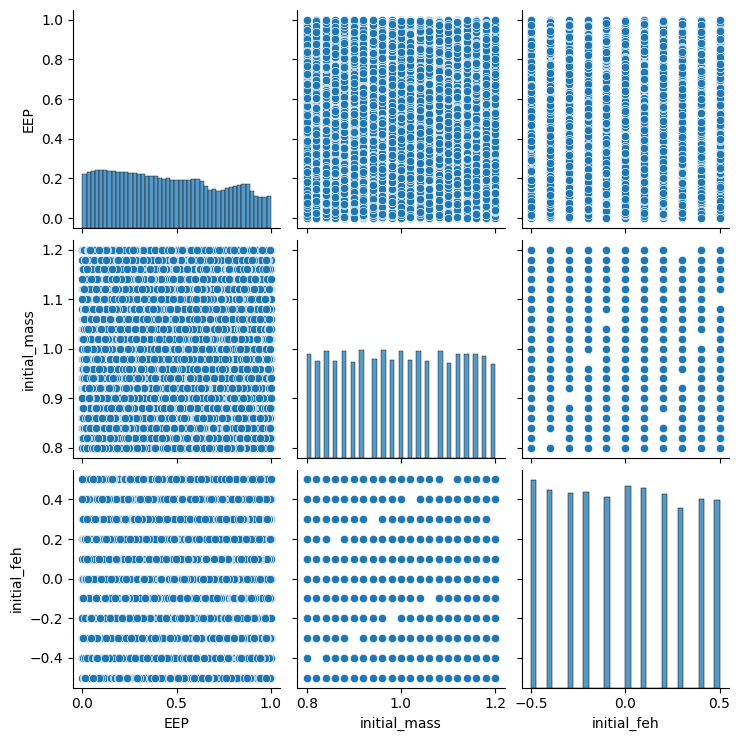

In [243]:
sns.pairplot(train, vars=input_cols);

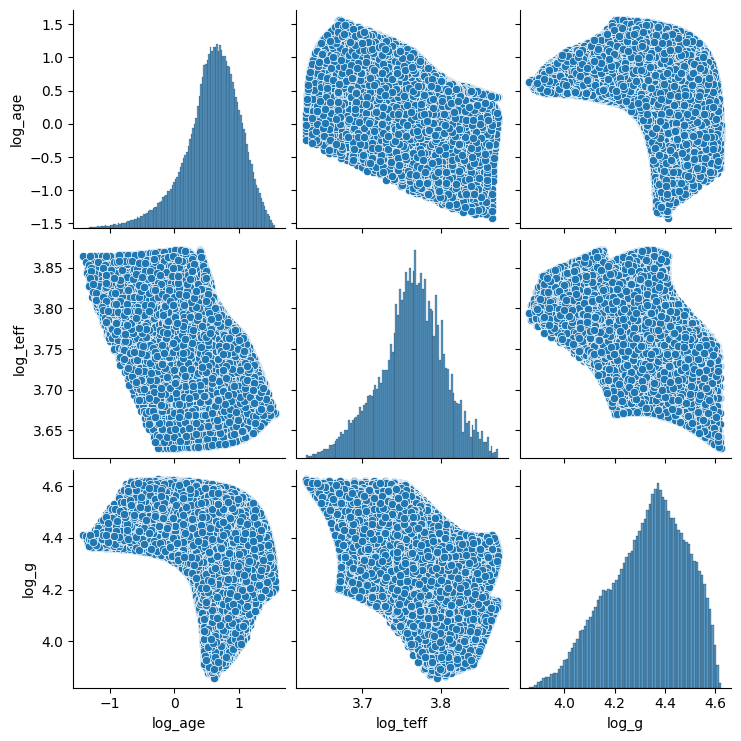

In [244]:
sns.pairplot(train, vars=output_cols);

In [245]:
input_normalizer = preprocessing.Normalization()
input_normalizer.adapt(train[input_cols].to_numpy())

print(input_normalizer.mean.numpy())
print(input_normalizer.variance.numpy())

[[ 0.45409417  0.99945694 -0.00805183]]
[[0.07933648 0.01457075 0.09994276]]


In [246]:
output_normalizer = preprocessing.Normalization()
output_normalizer.adapt(train[output_cols].to_numpy())

print(output_normalizer.mean.numpy())
print(output_normalizer.variance.numpy())

[[0.5909051 3.7629142 4.331652 ]]
[[0.18935992 0.00174252 0.02327497]]


In [247]:
output_rescaler = preprocessing.Rescaling(
    scale=output_normalizer.variance**0.5, 
    offset=output_normalizer.mean
)

In [248]:
def build_model(num_neurons, num_hidden, activation='relu', reg=0):
    l2reg = keras.regularizers.L2(reg)
    hidden_layers = [
        layers.Dense(num_neurons, activation=activation, kernel_regularizer=l2reg) for layer in range(num_hidden)
    ]
    all_layers = [input_normalizer] + hidden_layers + [layers.Dense(len(output_cols)), output_rescaler]
    return keras.Sequential(all_layers)

In [249]:
model = build_model(64, 2)
model.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(),
)
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 3)                7         
 ion)                                                            
                                                                 
 dense_124 (Dense)           (None, 64)                256       
                                                                 
 dense_125 (Dense)           (None, 64)                4160      
                                                                 
 dense_126 (Dense)           (None, 3)                 195       
                                                                 
 rescaling_2 (Rescaling)     (None, 3)                 0         
                                                                 
Total params: 4,618
Trainable params: 4,611
Non-trainable params: 7
___________________________________________________

In [250]:
epochs = 100
validation_split = 0.2
verbose = 0
batch_size = 2048
len(train)%batch_size

1722

In [251]:
%%time
history = model.fit(
    train[input_cols], train[output_cols],
    validation_split=validation_split,
    batch_size=batch_size,
    verbose=verbose, epochs=epochs,
)

CPU times: user 28.2 s, sys: 2.12 s, total: 30.3 s
Wall time: 27.5 s


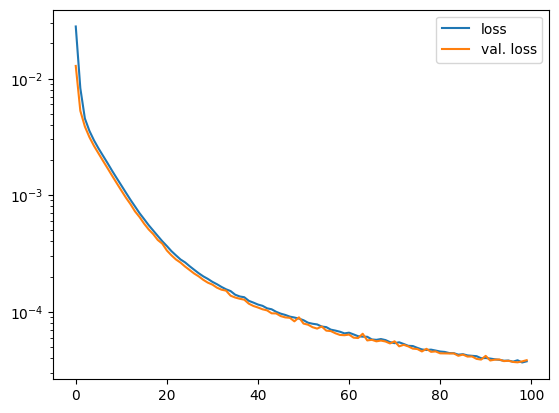

In [252]:
fig, ax = plt.subplots()

ax.plot(history.epoch, history.history['loss'], label='loss')
ax.plot(history.epoch, history.history['val_loss'], label='val. loss')

ax.set_yscale("log")
ax.legend();

Text(0.5, 1.0, 'validation loss')

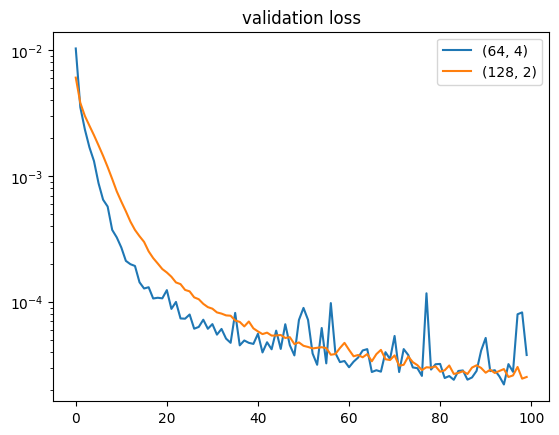

In [253]:
architectures = [(64, 4), (128, 2)]
histories = []

for arch in architectures:
    model = build_model(*arch)
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam())
    histories.append(model.fit(
      train[input_cols], train[output_cols],
      validation_split=validation_split,
      batch_size=batch_size,
      verbose=0, epochs=epochs,
    ))

fig, ax = plt.subplots()
for history, arch in zip(histories, architectures):
    ax.plot(history.epoch, history.history['val_loss'], label=arch)

ax.set_yscale('log')
ax.legend()
ax.set_title('validation loss')

Text(0.5, 1.0, 'validation loss')

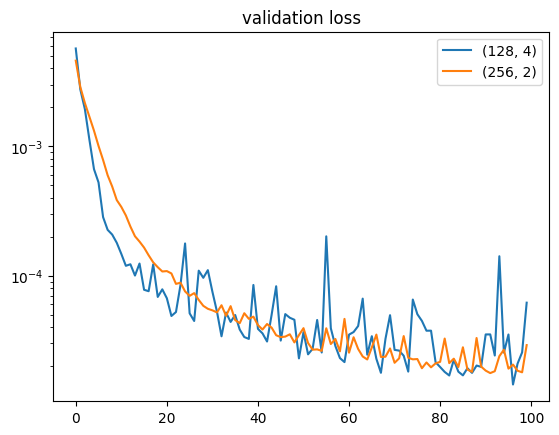

In [254]:
architectures = [(128, 4), (256, 2)]
histories = []

for arch in architectures:
    model = build_model(*arch)
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam())
    histories.append(model.fit(
      train[input_cols], train[output_cols],
      validation_split=validation_split,
      batch_size=batch_size,
      verbose=0, epochs=epochs,
    ))

fig, ax = plt.subplots()
for history, arch in zip(histories, architectures):
    ax.plot(history.epoch, history.history['val_loss'], label=arch)

ax.set_yscale('log')
ax.legend()
ax.set_title('validation loss')

Text(0.5, 1.0, 'validation loss')

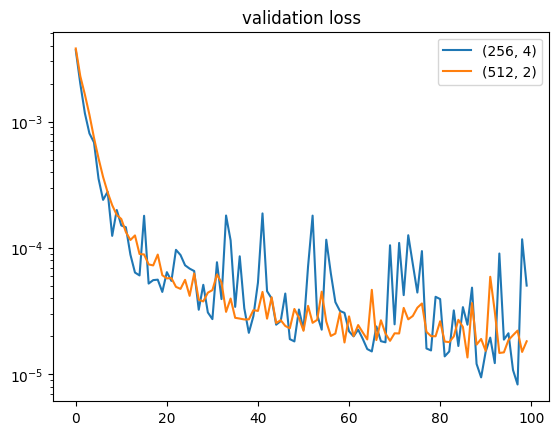

In [255]:
architectures = [(256, 4), (512, 2)]
histories = []

for arch in architectures:
    model = build_model(*arch)
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam())
    histories.append(model.fit(
      train[input_cols], train[output_cols],
      validation_split=validation_split,
      batch_size=batch_size,
      verbose=0, epochs=epochs,
    ))

fig, ax = plt.subplots()
for history, arch in zip(histories, architectures):
    ax.plot(history.epoch, history.history['val_loss'], label=arch)

ax.set_yscale('log')
ax.legend()
ax.set_title('validation loss')

In [256]:
model = build_model(512, 2, reg=0)

model.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(),
)
model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 3)                7         
 ion)                                                            
                                                                 
 dense_151 (Dense)           (None, 512)               2048      
                                                                 
 dense_152 (Dense)           (None, 512)               262656    
                                                                 
 dense_153 (Dense)           (None, 3)                 1539      
                                                                 
 rescaling_2 (Rescaling)     (None, 3)                 0         
                                                                 
Total params: 266,250
Trainable params: 266,243
Non-trainable params: 7
_______________________________________________

In [257]:
%%time
history = model.fit(
    train[input_cols], train[output_cols],
    validation_split=validation_split,
    batch_size=batch_size,
    verbose=verbose, epochs=1000,
)

CPU times: user 4min 36s, sys: 22.9 s, total: 4min 59s
Wall time: 4min 33s


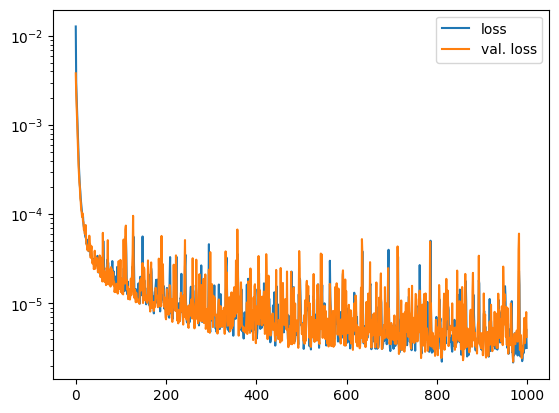

In [258]:
fig, ax = plt.subplots()

ax.plot(history.epoch, history.history['loss'], label='loss')
ax.plot(history.epoch, history.history['val_loss'], label='val. loss')

ax.set_yscale("log")
ax.legend();

## Test

In [259]:
pred = pd.DataFrame(
    model(test[input_cols]),
    columns=output_cols
)
pred.head()

,log_age,log_teff,log_g
0,-0.691999,3.748013,4.610300
1,-0.446583,3.747992,4.607012
2,-0.272094,3.748952,4.604259
3,-0.030859,3.749592,4.596473
4,-0.016508,3.749593,4.595908


In [266]:
err = test[output_cols].reset_index(drop=True) - pred
err.head()

,log_age,log_teff,log_g
0,-0.002278,-0.000131,0.002044
1,0.010110,0.000096,0.001107
2,0.009842,-0.000581,0.000122
3,0.004295,-0.000555,0.000662
4,0.004412,-0.000502,0.000661


In [261]:
frac_err = 10**log_err

In [262]:
err10 = 10**test[output_cols].reset_index(drop=True) - 10**pred

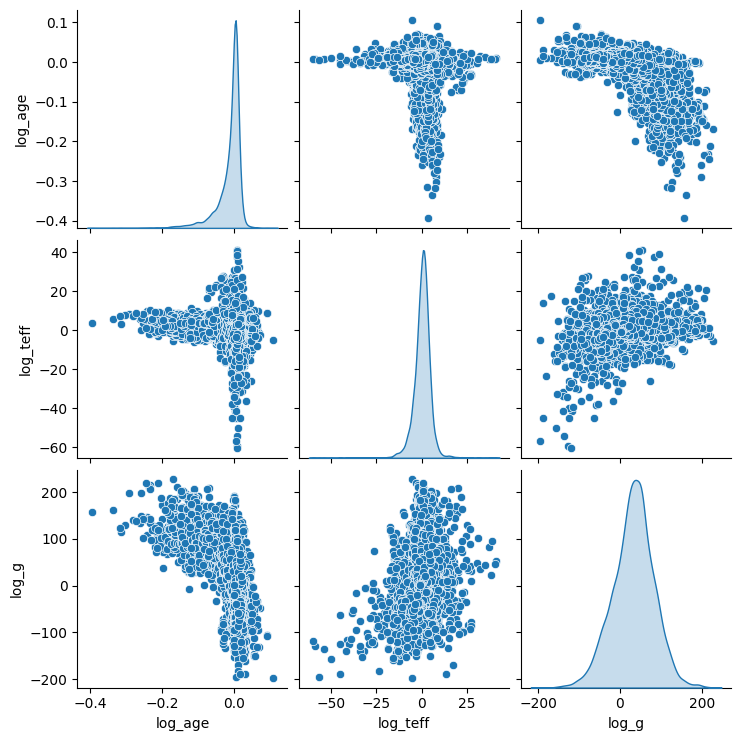

In [263]:
sns.pairplot(err10, diag_kind='kde');

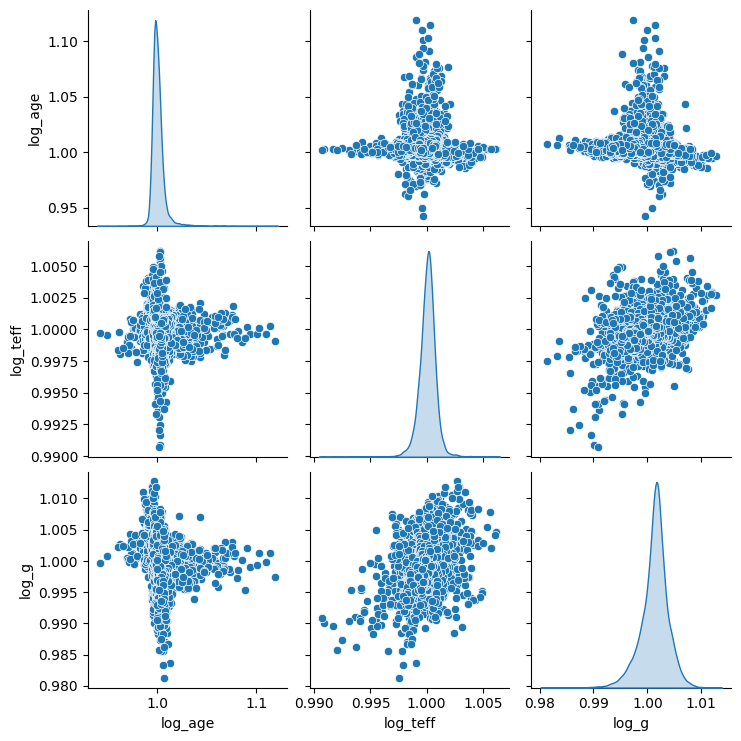

In [264]:
sns.pairplot(frac_err, diag_kind='kde');

In [111]:
from scipy.interpolate import LinearNDInterpolator, RegularGridInterpolator, interp1d

In [217]:
def interp_track(track, key, values):
    func = interp1d(track[key], track[output_cols], fill_value="extrapolate", axis=0)
    return pd.DataFrame(func(values), index=pd.Index(values, name=key), columns=output_cols)

In [226]:
eep = np.linspace(0., 1., 401)

train_eep = train.sort_values("EEP").groupby(
    ["initial_mass", "initial_feh"], 
    sort=False
).apply(interp_track, "EEP", eep).reset_index()
train_eep

,initial_mass,initial_feh,EEP,log_age,log_teff,log_g
0,0.84,-0.1,0.0000,-0.680083,3.729527,4.601496
1,0.84,-0.1,0.0025,-0.604619,3.729578,4.600445
2,0.84,-0.1,0.0050,-0.528526,3.729648,4.599346
3,0.84,-0.1,0.0075,-0.457156,3.729731,4.598257
4,0.84,-0.1,0.0100,-0.398191,3.729815,4.597290
...,...,...,...,...,...,...
89017,0.90,0.5,0.9900,1.383407,3.692762,4.184791
89018,0.90,0.5,0.9925,1.383916,3.692577,4.182658
89019,0.90,0.5,0.9950,1.384415,3.692383,4.180480
89020,0.90,0.5,0.9975,1.384911,3.692186,4.178304


In [227]:
mass = np.linspace(0.8, 1.2, 21)

train_eep = train_eep.sort_values("initial_mass").groupby(
    ["EEP", "initial_feh"], 
    sort=False
).apply(interp_track, "initial_mass", mass).reset_index()
train_eep

,EEP,initial_feh,initial_mass,log_age,log_teff,log_g
0,1.000,0.1,0.80,1.351879,3.714938,4.151461
1,1.000,0.1,0.82,1.313259,3.719007,4.143221
2,1.000,0.1,0.84,1.275268,3.722950,4.135193
3,1.000,0.1,0.86,1.238028,3.726592,4.125882
4,1.000,0.1,0.88,1.201152,3.730223,4.117550
...,...,...,...,...,...,...
92626,0.265,-0.4,1.12,0.192182,3.835215,4.317660
92627,0.265,-0.4,1.14,0.178332,3.840946,4.311900
92628,0.265,-0.4,1.16,0.176012,3.847026,4.305272
92629,0.265,-0.4,1.18,0.168683,3.853090,4.300944


In [228]:
feh = np.linspace(-0.5, 0.5, 11)

train_eep = train_eep.sort_values("initial_feh").groupby(
    ["EEP", "initial_mass"], 
    sort=False
).apply(interp_track, "initial_feh", feh).reset_index()
train_eep

,EEP,initial_mass,initial_feh,log_age,log_teff,log_g
0,0.9200,1.0,-0.5,0.733082,3.794805,3.983873
1,0.9200,1.0,-0.4,0.755223,3.789030,3.999474
2,0.9200,1.0,-0.3,0.785207,3.782614,4.018569
3,0.9200,1.0,-0.2,0.825045,3.775652,4.044081
4,0.9200,1.0,-0.1,0.876063,3.767888,4.073626
...,...,...,...,...,...,...
92626,0.4825,0.8,0.1,1.145935,3.714140,4.463676
92627,0.4825,0.8,0.2,1.210876,3.698874,4.467572
92628,0.4825,0.8,0.3,1.257779,3.685394,4.469142
92629,0.4825,0.8,0.4,1.312037,3.671060,4.473249


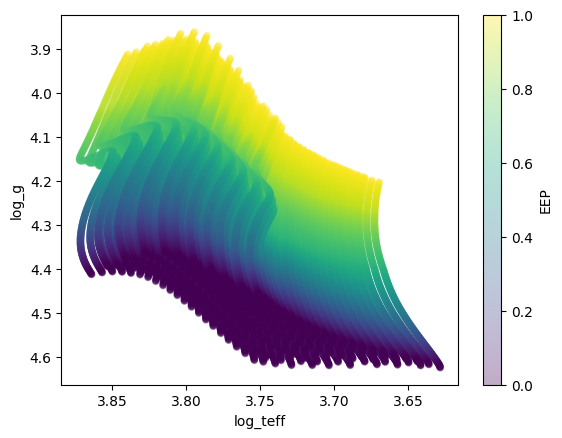

In [229]:
ax = train_eep.sort_values(input_cols, ascending=False).plot(
    x="log_teff", y="log_g", c="EEP", kind="scatter", cmap="viridis", alpha=0.33
)
ax.invert_xaxis()
ax.invert_yaxis()

In [231]:
from isochrones.interp import DFInterpolator

In [232]:
train_eep.set_index(input_cols)

,EEP,initial_mass,initial_feh,log_age,log_teff,log_g
0,0.9200,1.0,-0.5,0.733082,3.794805,3.983873
1,0.9200,1.0,-0.4,0.755223,3.789030,3.999474
2,0.9200,1.0,-0.3,0.785207,3.782614,4.018569
3,0.9200,1.0,-0.2,0.825045,3.775652,4.044081
4,0.9200,1.0,-0.1,0.876063,3.767888,4.073626
...,...,...,...,...,...,...
92626,0.4825,0.8,0.1,1.145935,3.714140,4.463676
92627,0.4825,0.8,0.2,1.210876,3.698874,4.467572
92628,0.4825,0.8,0.3,1.257779,3.685394,4.469142
92629,0.4825,0.8,0.4,1.312037,3.671060,4.473249


In [233]:
interp = DFInterpolator(train_eep.set_index(input_cols))

In [234]:
interp([0.5, 1., 0.])

array([0.69999192, 3.77015585, 4.33225179])

In [237]:
pred_interp = pd.DataFrame(
    interp(test[input_cols].to_numpy().T),
    columns=output_cols
)
pred_interp.head()

,log_age,log_teff,log_g
0,-0.694308,3.747869,4.612391
1,-0.439938,3.748088,4.608155
2,-0.263135,3.748371,4.604388
3,-0.027062,3.749037,4.597136
4,-0.012566,3.749092,4.596570


In [238]:
err_interp = test[output_cols].reset_index(drop=True) - pred_interp
err_interp.head()

,log_age,log_teff,log_g
0,0.000031,1.389194e-05,-0.000047
1,0.003464,-1.916844e-07,-0.000037
2,0.000883,-3.924786e-07,-0.000006
3,0.000497,-1.216317e-07,-0.000001
4,0.000469,-1.108345e-07,-0.000001


In [267]:
error = pd.concat(
    {"NN": err, "Interp": err_interp},
    names=["method"]
).reset_index(level=0).reset_index(drop=True)
error.head()

,method,log_age,log_teff,log_g
0,NN,-0.002278,-0.000131,0.002044
1,NN,0.010110,0.000096,0.001107
2,NN,0.009842,-0.000581,0.000122
3,NN,0.004295,-0.000555,0.000662
4,NN,0.004412,-0.000502,0.000661


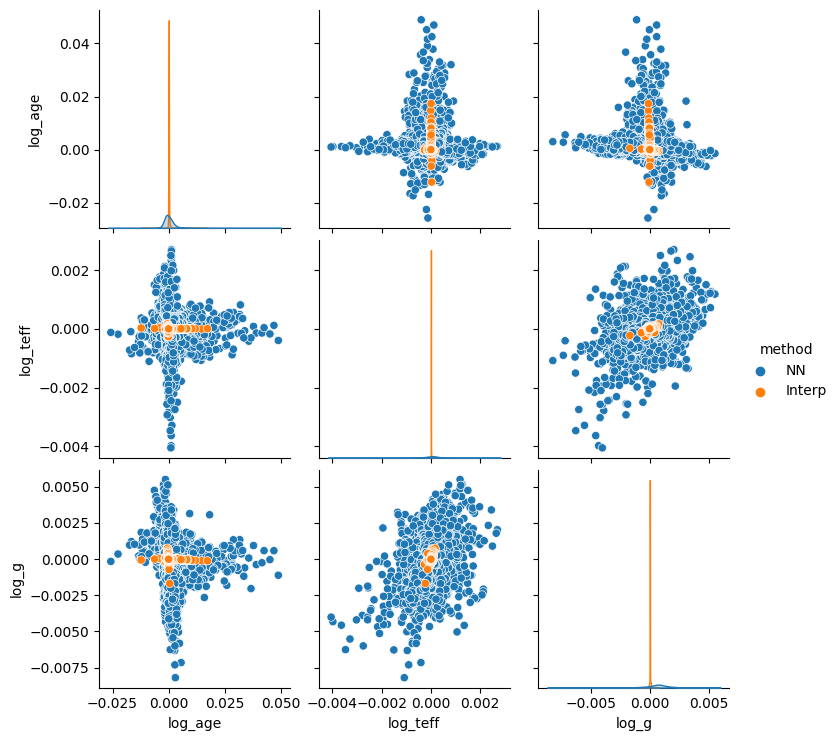

In [268]:
sns.pairplot(error, hue="method", diag_kind="kde", diag_kws=dict(common_norm=False));

In [94]:
model_tf = tf.function(model, jit_compile=True)

In [90]:
%%timeit
interp(test[input_cols].iloc[0])

449 µs ± 3.96 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [91]:
%%timeit
model(test[input_cols].iloc[0])

3.02 ms ± 275 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [96]:
%%timeit
model_tf(test[input_cols].iloc[0])

1.07 ms ± 38.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [97]:
%%timeit
interp(test[input_cols])

58.9 ms ± 438 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [98]:
%%timeit
model(test[input_cols])

3.22 ms ± 328 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [100]:
%%timeit
model_tf(test[input_cols])

1.85 ms ± 263 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [104]:
df.columns

Index(['index', 'dirname', 'filename', 'model_number', 'evol_stage',
       'initial_mass', 'initial_Yinit', 'initial_Zinit', 'initial_feh',
       'initial_MLT', 'initial_fov', 'star_mass', 'star_age', 'ms_age',
       'frac_age', 'effective_T', 'luminosity', 'radius', 'log_g',
       'surface_h1', 'surface_he4', 'surface_Z', 'star_feh', 'center_h1',
       'center_he4', 'log_center_T', 'log_center_Rho', 'he_core_mass',
       'delta_nu', 'delta_Pg', 'nu_max', 'acoustic_cutoff', 'nu_0_1', 'nu_0_2',
       'nu_0_3', 'nu_0_4', 'nu_0_5', 'nu_0_6', 'nu_0_7', 'nu_0_8', 'nu_0_9',
       'nu_0_10', 'nu_0_11', 'nu_0_12', 'nu_0_13', 'nu_0_14', 'nu_0_15',
       'nu_0_16', 'nu_0_17', 'nu_0_18', 'nu_0_19', 'nu_0_20', 'nu_0_21',
       'nu_0_22', 'nu_0_23', 'nu_0_24', 'nu_0_25', 'nu_0_26', 'nu_0_27',
       'nu_0_28', 'nu_0_29', 'nu_0_30', 'nu_0_31', 'nu_0_32', 'nu_0_33',
       'nu_0_34', 'nu_0_35', 'nu_0_36', 'nu_0_37', 'nu_0_38', 'nu_0_39',
       'nu_0_40', 'log_age', 'log_kron', 'kron', 'log

In [137]:
train_big = df.loc[train.index]
train_big = train_big.loc[train_big["nu_0_20"] != 0.0]

In [138]:
test_big = df.loc[test.index]
test_big = test_big.loc[test_big["nu_0_20"] != 0.0]

In [141]:
%%time
big_cols = output_cols + [f"nu_0_{i}" for i in range(5, 35)]
interp_big = LinearNDInterpolator(train_big[input_cols], train_big[big_cols])

CPU times: user 25.8 s, sys: 0 ns, total: 25.8 s
Wall time: 25.8 s


In [142]:
%%timeit
interp_big(test[input_cols].iloc[:100])

811 µs ± 232 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [143]:
pred_big = pd.DataFrame(
    interp_big(test_big[input_cols]),
    columns=big_cols
)

In [151]:
err_big = test_big[big_cols].reset_index(drop=True) - pred_big

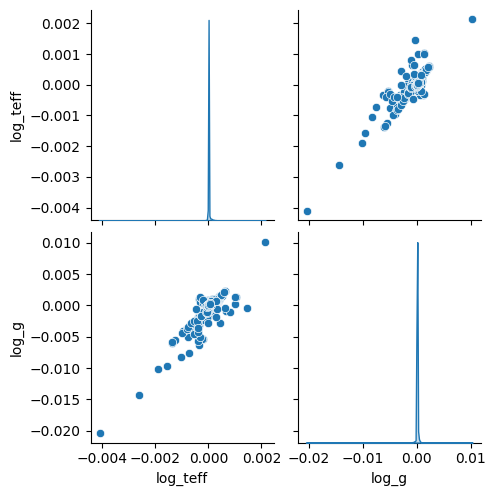

In [152]:
sns.pairplot(err_big, vars=output_cols, diag_kind='kde');

In [153]:
err_big

,log_teff,log_g,nu_0_5,nu_0_6,nu_0_7,nu_0_8,nu_0_9,nu_0_10,nu_0_11,nu_0_12,...,nu_0_25,nu_0_26,nu_0_27,nu_0_28,nu_0_29,nu_0_30,nu_0_31,nu_0_32,nu_0_33,nu_0_34
0,-1.248541e-06,0.000011,0.019651,0.023518,0.027257,0.030945,0.034729,0.038322,0.042359,0.045784,...,0.089419,0.092601,0.095842,0.099278,0.102386,0.105974,0.109043,0.112638,0.115883,0.119447
1,-6.924373e-07,0.000009,0.016763,0.019912,0.023049,0.026337,0.029242,0.032809,0.035624,0.039172,...,0.075450,0.078865,0.081431,0.083886,0.087487,0.089120,0.093301,0.095015,0.098674,0.101470
2,-1.655967e-06,0.000016,0.028298,0.033868,0.039294,0.044585,0.050131,0.055231,0.061039,0.065988,...,0.128767,0.133292,0.138055,0.142968,0.147462,0.152604,0.157126,0.162383,0.166927,0.172330
3,-1.626549e-06,0.000015,0.027899,0.033372,0.038712,0.043918,0.049371,0.054414,0.060114,0.065029,...,0.126812,0.131321,0.135961,0.140801,0.145220,0.150222,0.154700,0.159747,0.164206,0.169314
4,-6.600761e-07,0.000006,0.011478,0.013765,0.015984,0.018089,0.020397,0.022447,0.024779,0.026827,...,0.052361,0.054144,0.056102,0.058117,0.059873,0.062072,0.063832,0.065960,0.067799,0.069944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17197,-9.068146e-06,-0.000046,-0.043650,-0.050960,-0.058231,-0.064864,-0.071116,-0.077483,-0.084025,-0.090666,...,-0.178789,-0.185716,-0.192977,-0.199710,-0.206105,-0.213319,-0.222819,-0.236845,-0.241417,-0.245460
17198,1.827179e-06,0.000017,0.007549,0.008345,0.008944,0.009749,0.010775,0.011850,0.012936,0.014120,...,0.029764,0.031095,0.032932,0.034889,0.036934,0.037046,0.033433,0.034674,0.036449,0.038578
17199,2.649992e-05,0.000208,0.093745,0.103845,0.111766,0.121998,0.133779,0.146592,0.159642,0.172650,...,0.360219,0.375991,0.398593,0.423595,0.444001,0.433770,0.407234,0.426387,0.448173,0.471213
17200,6.771227e-05,0.000308,0.130071,0.142307,0.152716,0.165689,0.180471,0.195385,0.210651,0.226111,...,0.483255,0.503498,0.521237,0.526664,0.525543,0.540115,0.569135,0.595130,0.615205,0.628544


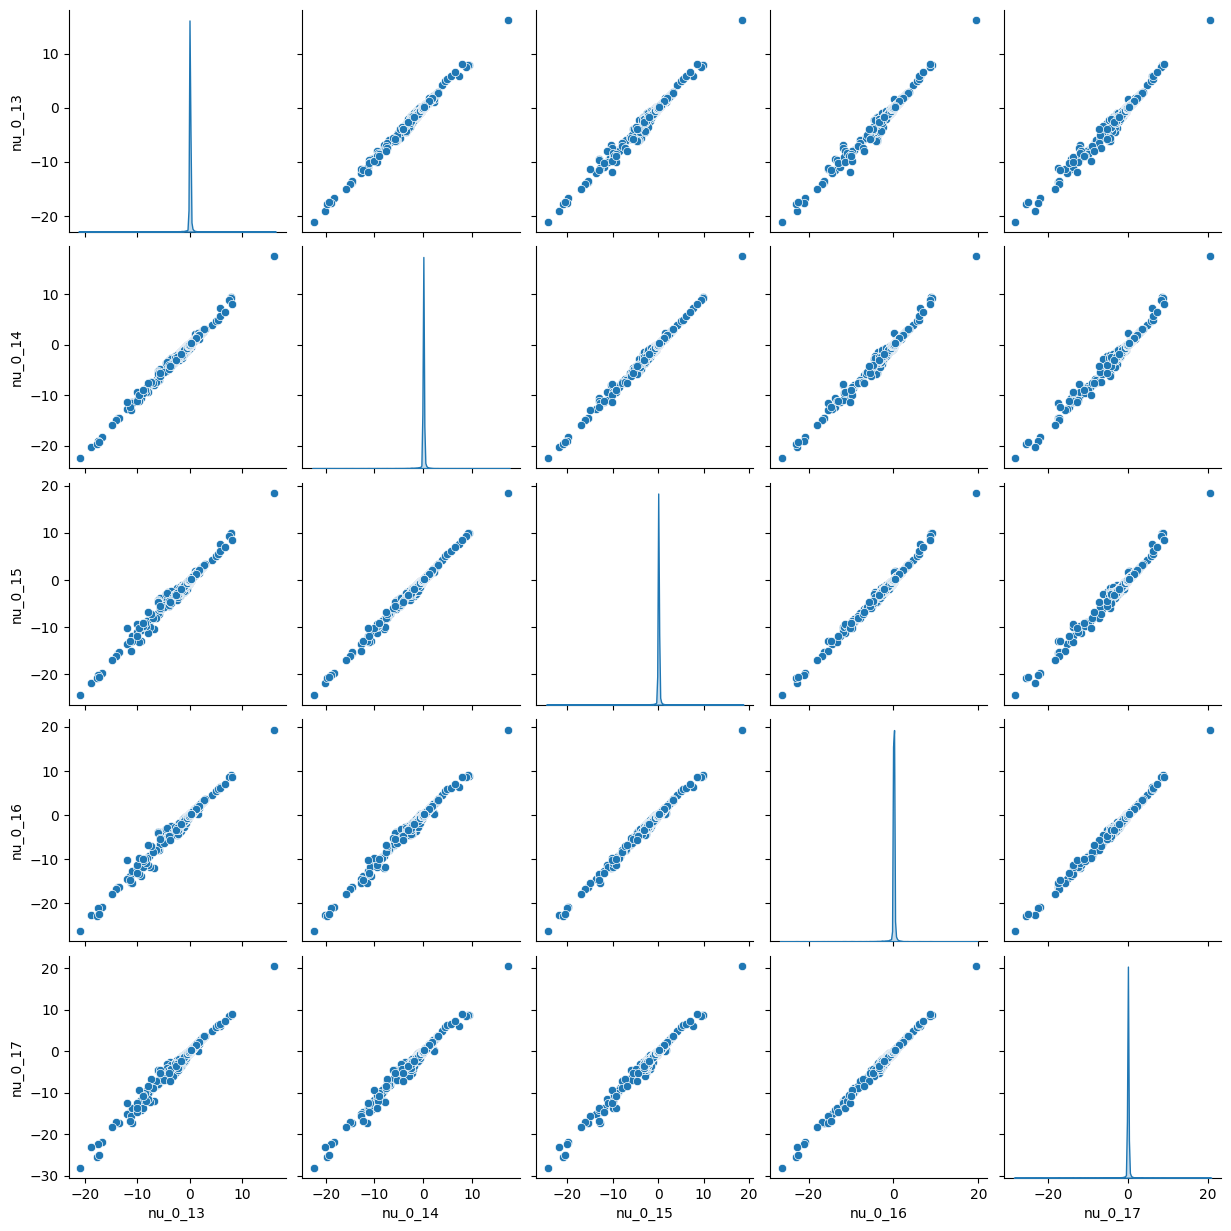

In [154]:
sns.pairplot(err_big, vars=big_cols[10:15], diag_kind='kde');